## Модель Хольта-Уинтерса

Модель Хольта-Уинтерса (Holt-Winters) — это аддитивная или мультипликативная модель временных рядов, которая учитывает **уровень**, **тренд** и **сезонность**. Она применяется для прогнозирования данных с выраженной сезонной компонентой.

### Основные компоненты модели
1. **Уровень (Level, $ L_t $)** — текущее среднее значение ряда.
2. **Тренд (Trend, $ T_t $)** — скорость изменения уровня.
3. **Сезонность (Seasonality, $ S_t $)** — периодические изменения в данных, повторяющиеся через фиксированные промежутки времени.

### Формулы модели (Аддитивный вариант)
Для аддитивной модели предполагается, что общий ряд складывается из трёх компонентов:
$$
Y_t = L_t + T_t + S_{t-m} + \varepsilon_t,
$$
где:
- $ Y_t $ — наблюдаемое значение ряда в момент времени $ t $;
- $ L_t $ — уровень в момент времени $ t $;
- $ T_t $ — тренд в момент времени $ t $;
- $ S_{t-m} $ — сезонность для текущего сезона ($ m $ — длина сезона);
- $ \varepsilon_t $ — случайный шум.

Обновление компонентов:
1. **Уровень:**
   $$
   L_t = \alpha (Y_t - S_{t-m}) + (1 - \alpha)(L_{t-1} + T_{t-1}),
   $$
   где $ \alpha $ — коэффициент сглаживания уровня ($ 0 \leq \alpha \leq 1 $).

2. **Тренд:**
   $$
   T_t = \beta (L_t - L_{t-1}) + (1 - \beta)T_{t-1},
   $$
   где $ \beta $ — коэффициент сглаживания тренда ($ 0 \leq \beta \leq 1 $).

3. **Сезонность:**
   $$
   S_t = \gamma (Y_t - L_t) + (1 - \gamma)S_{t-m},
   $$
   где $ \gamma $ — коэффициент сглаживания сезонности ($ 0 \leq \gamma \leq 1 $).

4. **Прогноз на будущее:**
   $$
   \hat{Y}_{t+k} = L_t + k \cdot T_t + S_{t-m+k},
   $$
   где $ k $ — шаг прогнозирования.

### Типы модели
1. **Аддитивная:** Сезонная компонента добавляется к уровню и тренду. Используется, когда амплитуда сезонных колебаний постоянна.
2. **Мультипликативная:** Сезонная компонента умножается на уровень и тренд. Используется, когда амплитуда сезонных колебаний изменяется пропорционально уровню.

### Работа модели
1. **Инициализация:** Определение начальных значений для $ L_0 $, $ T_0 $ и $ S_0 $.
2. **Обновление:** На каждом шаге модель пересчитывает значения уровня, тренда и сезонности, учитывая новые наблюдения.
3. **Прогнозирование:** На основе последних значений уровня, тренда и сезонности прогнозируются будущие значения временного ряда.

### Пример применения
Пример использования модели:
1. Прогнозирование продаж, где видна сезонность (например, летние товары или праздничные периоды).
2. Прогнозирование энергопотребления или климатических данных, где выражена годовая сезонность.

### Преимущества и ограничения
**Преимущества:**
- Простота реализации.
- Эффективность для данных с выраженной сезонностью.

**Ограничения:**
- Требуется явная сезонность в данных.
- Модель может быть чувствительна к выбросам.

---

### Основные параметры для тюнинга
1. **$ \alpha $:** Определяет, насколько быстро модель адаптируется к изменениям уровня.
2. **$ \beta $:** Контролирует скорость адаптации тренда.
3. **$ \gamma $:** Влияет на адаптацию сезонности.
4. **$ m $:** Длина сезона.


Метрики качества модели:
RMSE: 152.93
MAPE: 12.05%


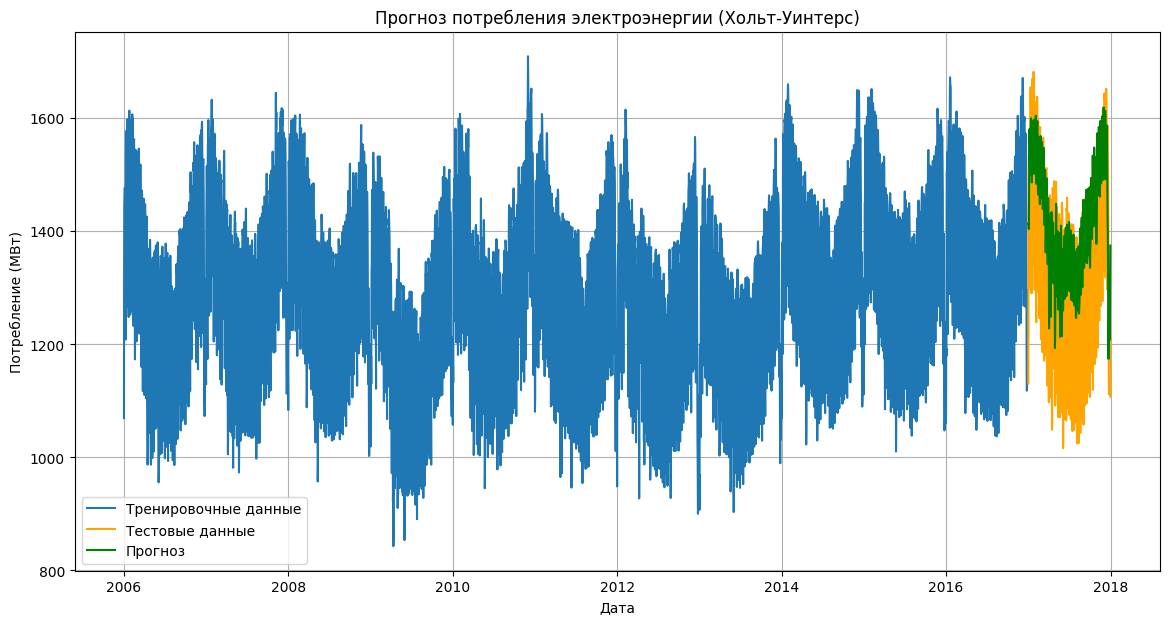

In [126]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

data = pd.read_csv('data/opsd_germany_daily.csv', parse_dates=['Date'])

# Подготовка данных: выбор столбца Consumption и настройка индекса
data = data[['Date', 'Consumption']].dropna()
data.set_index('Date', inplace=True)
data = data.asfreq('D')  # Установим дневную частоту

# Обучение модели Хольта-Уинтерса
train = data['Consumption'][:365 * 9]  # Первые 9 лет для обучения
test = data['Consumption'][365 * 9:]  # Остальное для тестирования

initial_season_length = 365

train = data[-initial_season_length*100:-initial_season_length]
test = data[-initial_season_length:]

# Учитываем сезонность (365 дней как длина сезона)
hw_model = ExponentialSmoothing(
    train,
    seasonal='add',
    seasonal_periods=365,
    trend='add'
).fit()

# Прогноз на период тестовых данных
forecast = hw_model.forecast(len(test))

# Расчет метрик качества на тестовом периоде
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test.values - forecast.values) / test.values)) * 100

# print(f"Сезонные коэффициенты:")
# for i, coef in enumerate(model.seasonal):
#     print(f"  Сезон {i+1}: {coef:.3f}")

print(f"\nМетрики качества модели:")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Сохраним параметры модели
model_params = hw_model.params

# Построим график прогноза
plt.figure(figsize=(14, 7))
plt.plot(train, label='Тренировочные данные')
plt.plot(test, label='Тестовые данные', color='orange')
plt.plot(forecast, label='Прогноз', color='green')
plt.legend()
plt.title('Прогноз потребления электроэнергии (Хольт-Уинтерс)')
plt.xlabel('Дата')
plt.ylabel('Потребление (МВт)')
plt.grid()
plt.show()

# model_params

Оптимизация параметров модели...
Размер временного ряда: 4383

Оптимальные параметры:
alpha (уровень): 0.999
beta (тренд): 0.001
gamma (сезонность): 0.001
Длина сезона: 365

Параметры модели:
Последний уровень: 1338.911
Тренд: -0.016

Метрики качества модели:
RMSE: 152.59
MAPE: 10.68%


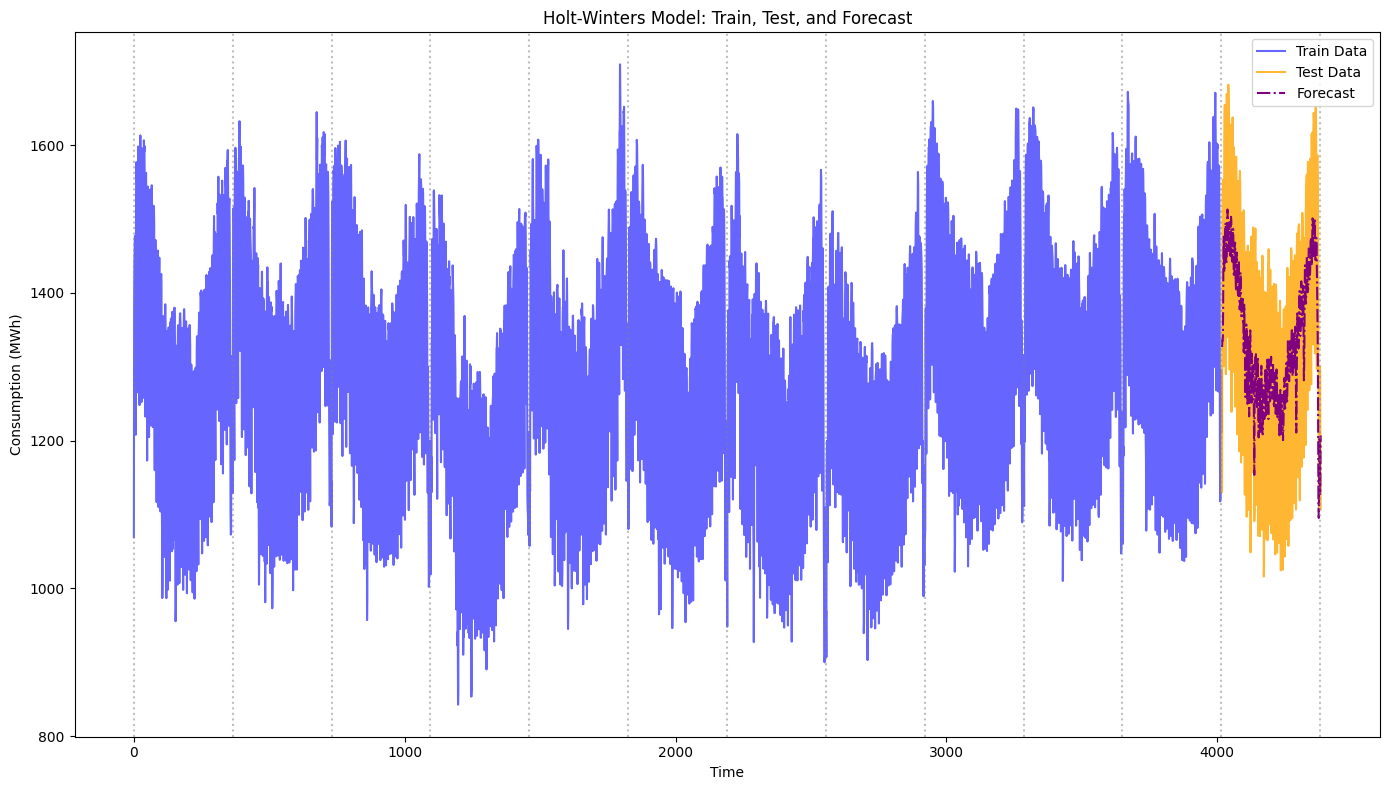

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class HoltWinters:
    def __init__(self, series, season_length=12, alpha=None, beta=None, gamma=None):
        self.series = np.array(series)
        self.season_length = season_length
        self.alpha = alpha if alpha is not None else 0.3
        self.beta = beta if beta is not None else 0.1
        self.gamma = gamma if gamma is not None else 0.1
        
        # Параметры модели
        self.level = None
        self.trend = None
        self.seasonal = None
        self.fitted = None
        self.residuals = None
        self.mse = None
        
    def initialize_components(self):
        n_seasons = len(self.series) // self.season_length
        
        # Инициализация сезонной компоненты
        seasonal_averages = np.zeros(self.season_length)
        for i in range(self.season_length):
            season_slice = self.series[i::self.season_length][:n_seasons]
            seasonal_averages[i] = np.mean(season_slice)
        
        # Нормализация сезонной компоненты
        self.seasonal = seasonal_averages - np.mean(seasonal_averages)
        
        # Инициализация уровня и тренда
        deseasoned = self.series[:(n_seasons * self.season_length)] - \
                    np.tile(self.seasonal, n_seasons)
        
        # Используем линейную регрессию для начальных значений уровня и тренда
        x = np.arange(len(deseasoned))
        coeffs = np.polyfit(x, deseasoned, 1)
        
        self.trend = coeffs[0]
        self.level = coeffs[1]
    
    def fit(self):
        self.initialize_components()
        n = len(self.series)
        self.fitted = np.zeros(n)
        
        for t in range(n):
            if t == 0:
                self.fitted[t] = self.level + self.seasonal[t % self.season_length]
                continue
                
            # Прогноз на текущий шаг
            self.fitted[t] = self.level + self.trend + \
                            self.seasonal[t % self.season_length]
                        
            # Обновление компонент
            old_level = self.level
            self.level = self.alpha * (self.series[t] - \
                        self.seasonal[t % self.season_length]) + \
                        (1 - self.alpha) * (old_level + self.trend)
            
            self.trend = self.beta * (self.level - old_level) + \
                        (1 - self.beta) * self.trend
            
            self.seasonal[t % self.season_length] = self.gamma * \
                                                   (self.series[t] - self.level) + \
                                                   (1 - self.gamma) * \
                                                   self.seasonal[t % self.season_length]
        
        self.residuals = self.series - self.fitted
        self.mse = mean_squared_error(self.series, self.fitted)
        return self
    
    def forecast(self, h=1):
        """
        Прогнозирование на h шагов вперед
        """
        forecasts = np.zeros(h)
        
        for t in range(h):
            forecasts[t] = self.level + (t + 1) * self.trend + \
                          self.seasonal[(len(self.series) + t) % self.season_length]
        
        return forecasts

def optimize_parameters(series, season_length=12, optimize_season=False):
    """
    Оптимизация параметров модели с помощью минимизации MSE
    """
    def objective(params):
        if optimize_season:
            alpha, beta, gamma, s_length = params
            s_length = int(round(s_length))
        else:
            alpha, beta, gamma = params
            s_length = season_length
            
        if not (0 < alpha < 1 and 0 < beta < 1 and 0 < gamma < 1):
            return float('inf')
        
        if optimize_season and not (4 <= s_length <= len(series) // 5):
            return float('inf')
            
        try:
            model = HoltWinters(series, season_length=s_length,
                              alpha=alpha, beta=beta, gamma=gamma)
            model.fit()
            return model.mse
        except:
            return float('inf')
    
    # Начальные значения для оптимизации
    if optimize_season:
        x0 = [0.3, 1., 10., season_length]
        bounds = [(0.001, 0.999), (0.001, 0.999), (0.001, 0.999),
                 (4, len(series) + 5)]
    else:
        x0 = [0.3, 0.1, 0.1]
        bounds = [(0.001, 0.999), (0.001, 0.999), (0.001, 0.999)]
    
    # Оптимизация
    result = minimize(objective, x0, method='L-BFGS-B', bounds=bounds)
    
    if optimize_season:
        alpha, beta, gamma, s_length = result.x
        s_length = int(round(s_length))
    else:
        alpha, beta, gamma = result.x
        s_length = season_length
        
    return alpha, beta, gamma, s_length

def plot_results(train_data, test_data, fitted_data, forecast, season_length):
    """
    Построение графика с обучающими, тестовыми и прогнозными данными.
    
    train_data: массив с обучающими данными
    test_data: массив с тестовыми данными
    fitted_data: массив с предсказаниями модели для обучающих данных
    forecast: массив с прогнозами на h шагов вперед
    season_length: длина сезона (используется для корректного отображения)
    """
    plt.figure(figsize=(14, 8))
    
    n_train = len(train_data)
    n_test = len(test_data)
    x_train = np.arange(n_train)
    x_test = np.arange(n_train, n_train + n_test)
    x_forecast = np.arange(n_train, n_train + len(forecast))
    
    # Отображение обучающей выборки
    plt.plot(x_train, train_data, label='Train Data', color='blue', alpha=0.6)
    # plt.plot(x_train, fitted_data[:n_train], label='Fitted Train Data', color='red', linestyle='--')
    
    # Отображение тестовой выборки
    plt.plot(x_test, test_data, label='Test Data', color='orange', alpha=0.8)
    # plt.plot(x_test, fitted_data[-n_test:], label='Fitted Test Data', color='green', linestyle='--')
    
    # Прогноз
    plt.plot(x_forecast, forecast, label='Forecast', color='purple', linestyle='-.')
    
    # Обозначения сезонности (опционально)
    for i in range(0, len(train_data) + len(forecast), season_length):
        plt.axvline(i, color='gray', linestyle=':', alpha=0.5)
    
    plt.title("Holt-Winters Model: Train, Test, and Forecast")
    plt.xlabel("Time")
    plt.ylabel("Consumption (MWh)")
    plt.legend()
    # plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def main():
    # Загрузка и подготовка данных
    data = pd.read_csv('data/opsd_germany_daily.csv', parse_dates=['Date'])
    
    # Используем данные потребления электроэнергии
    time_series = data['Consumption'].values
    
    # Предполагаем недельную сезонность (7 дней) и годовую (365 дней)
    # Для начала попробуем недельную сезонность
    initial_season_length = 365

    train_data = time_series[-initial_season_length*100:-initial_season_length]
    test_data = time_series[-initial_season_length:]
    
    # Оптимизация параметров
    print("Оптимизация параметров модели...")
    print("Размер временного ряда:", len(time_series))
    
    alpha, beta, gamma, opt_season_length = optimize_parameters(
        train_data, season_length=initial_season_length, optimize_season=True
    )
    
    print(f"\nОптимальные параметры:")
    print(f"alpha (уровень): {alpha:.3f}")
    print(f"beta (тренд): {beta:.3f}")
    print(f"gamma (сезонность): {gamma:.3f}")
    print(f"Длина сезона: {opt_season_length}")
    
    # Создание и обучение модели с оптимальными параметрами
    # Используем последний год данных для финальной модели
    
    model = HoltWinters(
        train_data,
        season_length=opt_season_length,
        alpha=alpha,
        beta=beta,
        gamma=gamma
    )
    model.fit()
    
    # Прогнозирование
    forecast = model.forecast(len(test_data))  # прогноз на длину тестовой выборки

    # Расчет метрик качества на тестовом периоде
    mse = mean_squared_error(test_data, forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
    
    print(f"\nПараметры модели:")
    print(f"Последний уровень: {model.level:.3f}")
    print(f"Тренд: {model.trend:.3f}")
    # print(f"Сезонные коэффициенты:")
    # for i, coef in enumerate(model.seasonal):
    #     print(f"  Сезон {i+1}: {coef:.3f}")
    
    print(f"\nМетрики качества модели:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    # print(f"\nПрогноз потребления электроэнергии на следующие {h} дней:")
    # last_date = pd.to_datetime(data['Date'].iloc[-1])
    # for i, value in enumerate(forecast):
    #     forecast_date = last_date + pd.Timedelta(days=i+1)
    #     print(f"{forecast_date.date()}: {value:.2f} MWh")
    
    plot_results(
        train_data=train_data,
        test_data=test_data,
        fitted_data=model.fitted,
        forecast=forecast,
        season_length=opt_season_length
    )

if __name__ == "__main__":
    main()